<a href="https://colab.research.google.com/github/ogtaylor2008837/mediamix/blob/main/mmm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective**

1. How much of sales within a period was generated by TV advertising?

2. How much by radio and web banners?

3. What is the baseline, i.e. the number of sales we would have had without any advertising?

**NB**: Assuming advertising activities are only on these channels

Sales = f(TV) + g(Radio) + h(Banners) + Base

To achieve this, the linear regression formula is utilised

y = b0 + b1x1 + b2x2 + ... + bn*xn

**where**:

y is the dependent variable (the variable being predicted or explained), b0 is the y-intercept (the value of y when all independent variables are zero), b1, b2, ..., bn are the coefficients (also known as slopes or weights) that represent the effect of each independent variable on the dependent variable, x1, x2, ..., xn are the independent variables.

In other to improve the performance of the model, advertising adstock also needs to be accounted for. In this model, the adstock will account for the effect of diminshing returns or satuartion and carryover effect(T+x)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ogtaylor2008837/mediamix/main/media_data.csv?token=GHSAT0AAAAAACDAFG2IYQXZDF5NHUSSWV44ZDMZ7NQ', parse_dates=['Date'], index_col='Date')
data.head()

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,9779.80
2018-01-14,0.0,5349.65,2218.93,13245.19
2018-01-21,0.0,4235.86,2046.96,12022.66
2018-01-28,0.0,3562.21,0.00,8846.95
2018-02-04,0.0,0.00,2187.29,9797.07


In [3]:
print(data.shape, '\n')
print(data.dtypes,'\n')
print(data.isnull().sum(),'\n')

(200, 4) 

TV         float64
Radio      float64
Banners    float64
Sales      float64
dtype: object 

TV         0
Radio      0
Banners    0
Sales      0
dtype: int64 



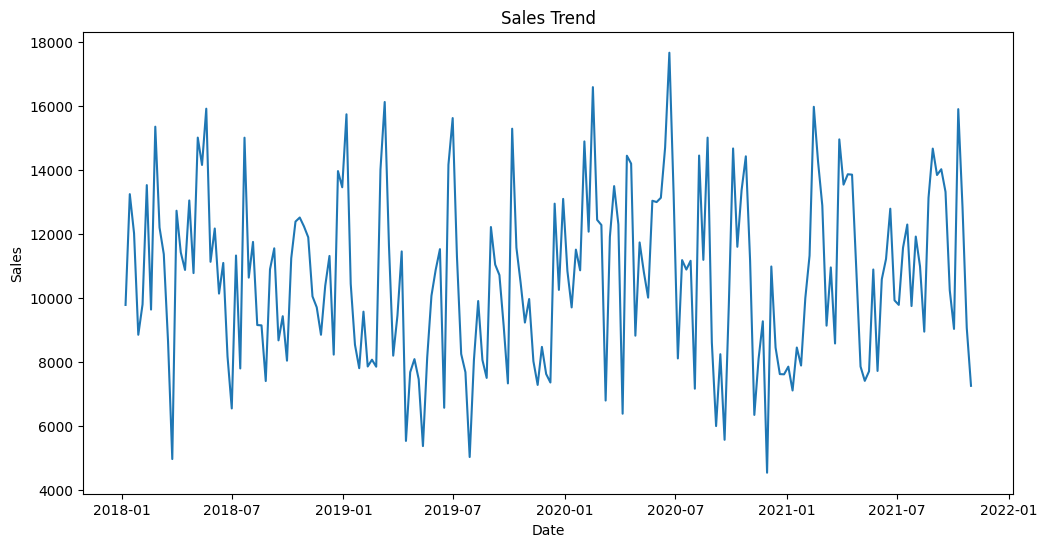

In [4]:
plt.figure(figsize=(12, 6))

plt.plot(data.index, data['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend')
plt.show()

To account for Saturation, I will create a simple class

In [5]:
class ExponenetialSaturation:
  def __init__(self, a=1.):
    self.a = a

  def transform(self, X):
    return 1 - np.exp(-self.a*X)

To make it scikit-learn compliant

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class ExponentialSaturation(BaseEstimator, TransformerMixin):
  def __init__(self, a=1.):
    self.a = a

  def fit(self, X, y=None):
    X = check_array(X)
    self._check_n_features(X, reset=True)  # from BaseEstimator
    return self

  def transform(self, X):
    check_is_fitted(self)
    X = check_array(X)
    self._check_n_features(X, reset=False)  # from BaseEstimator
    return 1 - np.exp(-self.a*X)

Carryover Effect

In [7]:
from scipy.signal import convolve2d
import numpy as np

class ExponentialCarryover(BaseEstimator, TransformerMixin):
  def __init___(self, strength=0.5, length=1):
    self.strength = strength
    self.length = length

  def fit(self, X, y=None):
    X = check_array(X)
    self._check_n_features(X, reset=True)
    self.sliding_window_ = (self.strength ** np.arange(self.length + 1)).reshape(-1, 1)
    return self

  def transform(self, X: np.ndarray):
    check_is_fitted(self)
    X = check_array(X)
    self._check_n_features(X, reset=False)
    convolution = convolve2d(X, self.sliding_window_)
    if self.length > 0:
      convolution = convolution[: -self.length]
    return convolution

In other to build the model. I will combine the saturation and carryover effects. Different saturations and carryovers will be used for each channel as Tv ads for example usually sticks longer in one's head than onlinr banner.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer([('tv_pipe', Pipeline([('carryover', ExponentialCarryover()),
                                                   ('saturation', ExponentialSaturation)
                            ]), ['TV']),
                            ('radio_pipe', Pipeline([('carryover', ExponentialCarryover()),
                                                   ('saturation', ExponentialSaturation)
                            ]), ['Radio']),
                            ('banners_pipe', Pipeline([('carryover', ExponentialCarryover()),
                                                   ('saturation', ExponentialSaturation)
                            ]), ['Banners']), 
                          ], 
                            remainder='passthrough'
                            )

model = Pipeline([('adstock', adstock),
                  ('Regression', LinearRegression())
])

What the code above simply does is to apply the adstock transformers through a pipeline for each columns.

The model object is then created through a pipeline that defines a series of steps as follows:
1. The adstock transformer is applied to the data
2. Then the linear regression estimator is also applied

In other to fit the model to our data, we need to

In [13]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
XX = data.drop(columns='Sales')
yy = data['Sales']

model.fit(XX, yy)

AttributeError: ignored